In [1]:
import os
import pandas as pd
import numpy as np
import mne
from xgboost import XGBClassifier
from boruta import BorutaPy
from BorutaShap import BorutaShap, load_data
from sklearn.model_selection import train_test_split

In [4]:
all_ids_og = ['S7068', 'S7070', 'S7071', 'S7074', 'S7086', 'S7091', 'S7098', 'S7101',
          'S7063', 'S7064', 'S7069', 'S7072', 'S7075', 'S7076', 'S7088', 'S7092', 'S7094'] #'S7096'


In [5]:
#Add genotypes
all_animals = pd.read_csv('/home/melissa/RESULTS/FINAL_MODEL/Rat/all_measures_xgboost.csv')
all_animals.drop(['Unnamed: 0'], axis = 1, inplace = True)

## Skip next cells to avoid graph theory features 

In [ ]:
frequency_bands = ['delta', 'theta', 'sigma', 'beta', 'gamma']

In [ ]:
coh_graph_theory = '/home/melissa/RESULTS/FINAL_MODEL/Rat/Graph_Theory/coh/'
pli_graph_theory = '/home/melissa/RESULTS/FINAL_MODEL/Rat/Graph_Theory/pli/'
plv_graph_theory = '/home/melissa/RESULTS/FINAL_MODEL/Rat/Graph_Theory/plv/'
wpli_graph_theory = '/home/melissa/RESULTS/FINAL_MODEL/Rat/Graph_Theory/wpli/'

all_bands = []
for band in frequency_bands:
    coh_df = pd.read_csv(coh_graph_theory + 'coh_' + str(band) + '.csv')
    pli_df = pd.read_csv(pli_graph_theory + 'pli_' + str(band) + '.csv')
    plv_df = pd.read_csv(plv_graph_theory + 'plv_' + str(band) + '.csv')
    wpli_df = pd.read_csv(wpli_graph_theory + 'wpli_' + str(band) + '.csv')
    coh_df.drop(['Unnamed: 0', 'Idx', 'Animal_ID'], axis = 1, inplace = True)
    pli_df.drop(['Unnamed: 0', 'Idx', 'Animal_ID'], axis = 1, inplace = True)
    plv_df.drop(['Unnamed: 0', 'Idx', 'Animal_ID'], axis = 1, inplace = True)
    wpli_df.drop(['Unnamed: 0', 'Idx', 'Animal_ID'], axis = 1, inplace = True)
    test_concat = pd.concat([coh_df, pli_df, plv_df, wpli_df], axis = 1)
    all_bands.append(test_concat)

In [ ]:
all_graph_arrays = pd.concat(all_bands, axis = 1)

In [ ]:
coh_df = pd.read_csv(coh_graph_theory + 'coh_' + str(band) + '.csv')
animal_id_list = coh_df['Animal_ID']
all_graph_arrays['Animal_ID'] = animal_id_list

In [ ]:
all_graph_arrays

In [ ]:
all_features_ls = []
for animal in all_ids:
    animal_features = all_animals.loc[all_animals['Animal_ID'] == str(animal)]
    graph_features = all_graph_arrays.loc[all_graph_arrays['Animal_ID'] == str(animal)]
    graph_features.drop(['Animal_ID'], axis = 1, inplace = True)
    all_features = pd.concat([animal_features, graph_features], axis = 1)
    all_features_ls.append(all_features)

In [ ]:
final_dataframe = pd.concat(all_features_ls, axis = 0)
final_dataframe

In [ ]:
all_animals

## Continue from here to avoid graph features 

In [9]:
df_cleaned = all_animals.dropna().reset_index(drop=True)
any_na_remaining = df_cleaned.isna().values.any()
any_na_remaining

False

In [10]:
wt_ids = ['S7068', 'S7070', 'S7071', 'S7074', 'S7086', 'S7091', 'S7098', 'S7101'] #'S7087',
gap_ids = ['S7063', 'S7064', 'S7069', 'S7072', 'S7075', 'S7076', 'S7088', 'S7092', 'S7094'] #, 'S7096'

In [11]:
def determine_genotype(animal_id, wt_ids, gap_ids):
    if animal_id in wt_ids:
        return 0  # WT
    elif animal_id in gap_ids:
        return 1  # GAP
    else:
        return None  # In case the ID is not found in either list

# Apply the function to each row in the DataFrame and ensure the type is integer
all_animals['Genotype'] = all_animals['Animal_ID'].apply(lambda x: determine_genotype(x, wt_ids, gap_ids)).astype('Int64')

# Move 'Genotype' column to the first position
cols = all_animals.columns.tolist()
cols.insert(0, cols.pop(cols.index('Genotype')))
all_animals = all_animals[cols]

In [13]:
# Combine the two lists and create a list of labels (0 for human_wt and 1 for human_gap)
all_ids = np.unique(df_cleaned['Animal_ID'].to_list())
labels = [0] * len(wt_ids) + [1] * len(gap_ids)

# Split the combined list into training and test sets, stratifying by the labels
train_ids, test_ids,_, _ = train_test_split(all_ids, labels, test_size=0.3, stratify=labels, random_state=42)

In [15]:
X_train = df_cleaned[df_cleaned["Animal_ID"].isin(train_ids)]
X_test = df_cleaned[df_cleaned["Animal_ID"].isin(test_ids)]

group_by_patient_id = X_train.groupby(['Animal_ID'])
groups_by_patient_id_list = np.array(X_train['Animal_ID'].values)

In [16]:
X_train_new = X_train.iloc[:, 3:]
X_test_new = X_test.iloc[:, 3:]
y_train = X_train.iloc[:, 0]
y_test = X_test.iloc[:, 0]

In [17]:
estimator_borutashap=XGBClassifier(n_jobs = -1,
                                           random_state=42,
                                           max_depth=4)
borutashap = BorutaShap(model = estimator_borutashap,
                            importance_measure = 'shap',
                            classification = True)
borutashap.fit(X = X_train_new, y = y_train, 
                   n_trials = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

82 attributes confirmed important: ['Mot_CC_Gamma', 'Somatosensory_coh_gamma', 'Vis_CC_Beta', 'Somatosensory_plv_theta', 'Visual_plv_beta', 'Visual_plv_sigma', 'Mot_CC_Beta', 'Som_CC_Gamma', 'Vis_Mot_pli_sigma', 'Vis_Mot_wpli_sigma', 'Visual_wpli_sigma', 'Vis_Mot_coh_beta', 'Somatosensory_coh_beta', 'Vis_Soma_plv_sigma', 'Somatosensory_wpli_beta', 'Vis_CC_Theta', 'Som_CC_Sigma', 'Soma_Motor_pli_beta', 'Som_CC_Beta', 'Visual_coh_beta', 'Visual_coh_gamma', 'Mot_Disp', 'Soma_Motor_pli_gamma', 'Somatosensory_wpli_gamma', 'Vis_Mot_plv_gamma', 'Somatosensory_pli_beta', 'Soma_Motor_coh_gamma', 'Motor_wpli_gamma', 'Somatosensory_plv_gamma', 'Soma_Motor_plv_beta', 'Somatosensory_plv_delta', 'Visual_plv_gamma', 'Mot_CC_Delta', 'Som_CC_Theta', 'Somatosensory_coh_theta', 'Vis_Mot_pli_gamma', 'Vis_Soma_pli_gamma', 'Vis_Mot_plv_sigma', 'Vis_Soma_plv_theta', 'Motor_wpli_theta', 'Vis_Soma_coh_delta', 'Vis_Soma_plv_gamma', 'Motor_pli_beta', 'Visual_pli_sigma', 'Vis_Soma_plv_delta', 'Motor_pli_theta', '

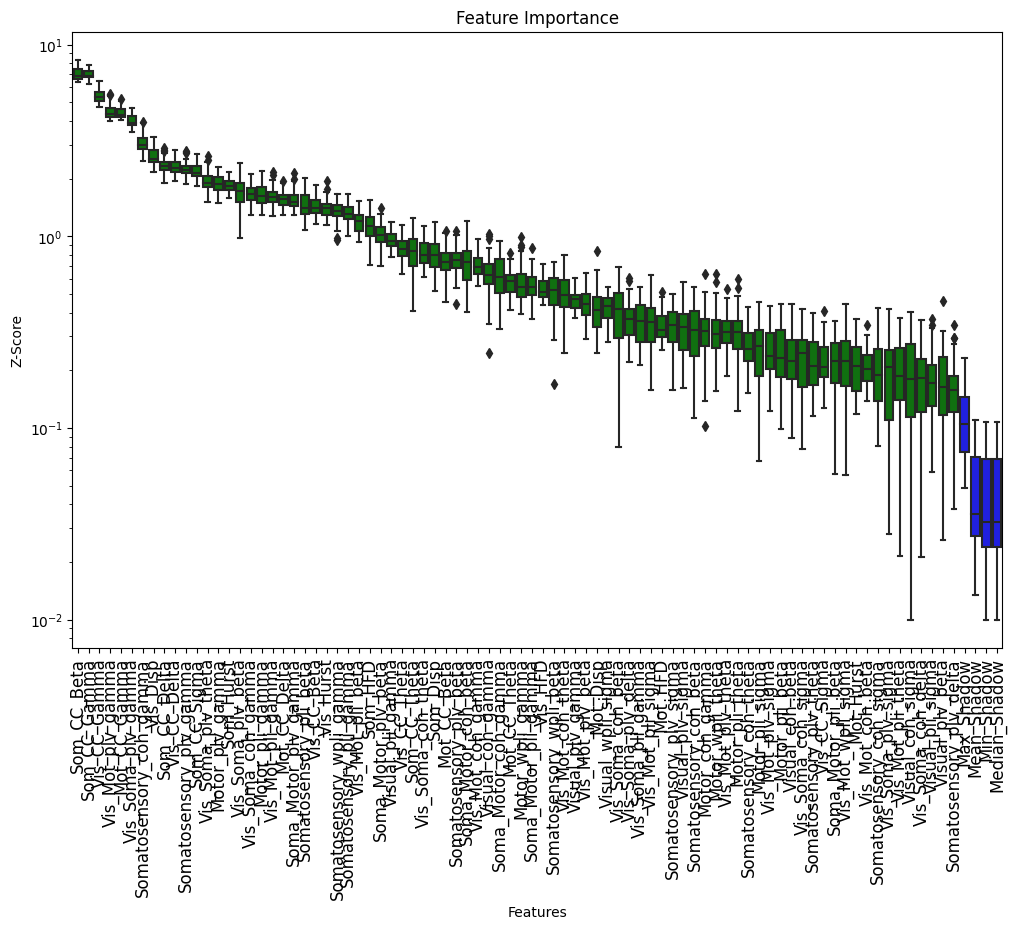

In [18]:
borutashap.plot(X_size=12, figsize=(12,8),
            y_scale='log', which_features='accepted')

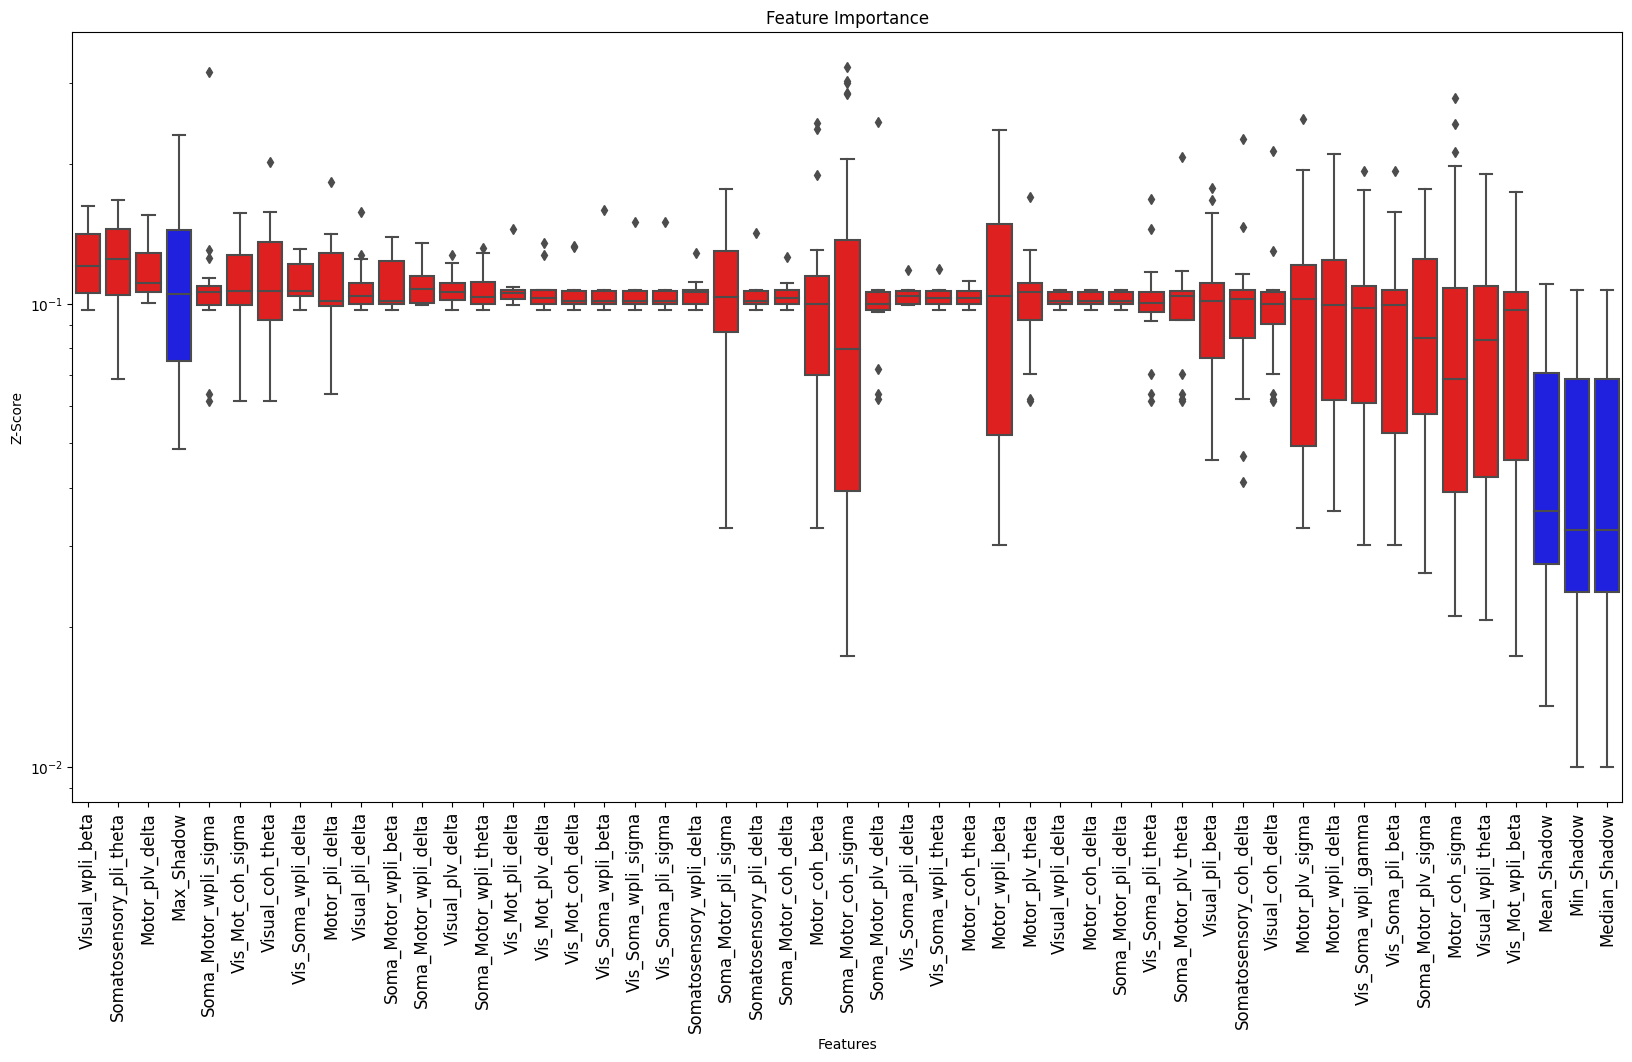

In [20]:
borutashap.plot(X_size=12, figsize=(20,10),
            y_scale='log', which_features='rejected')

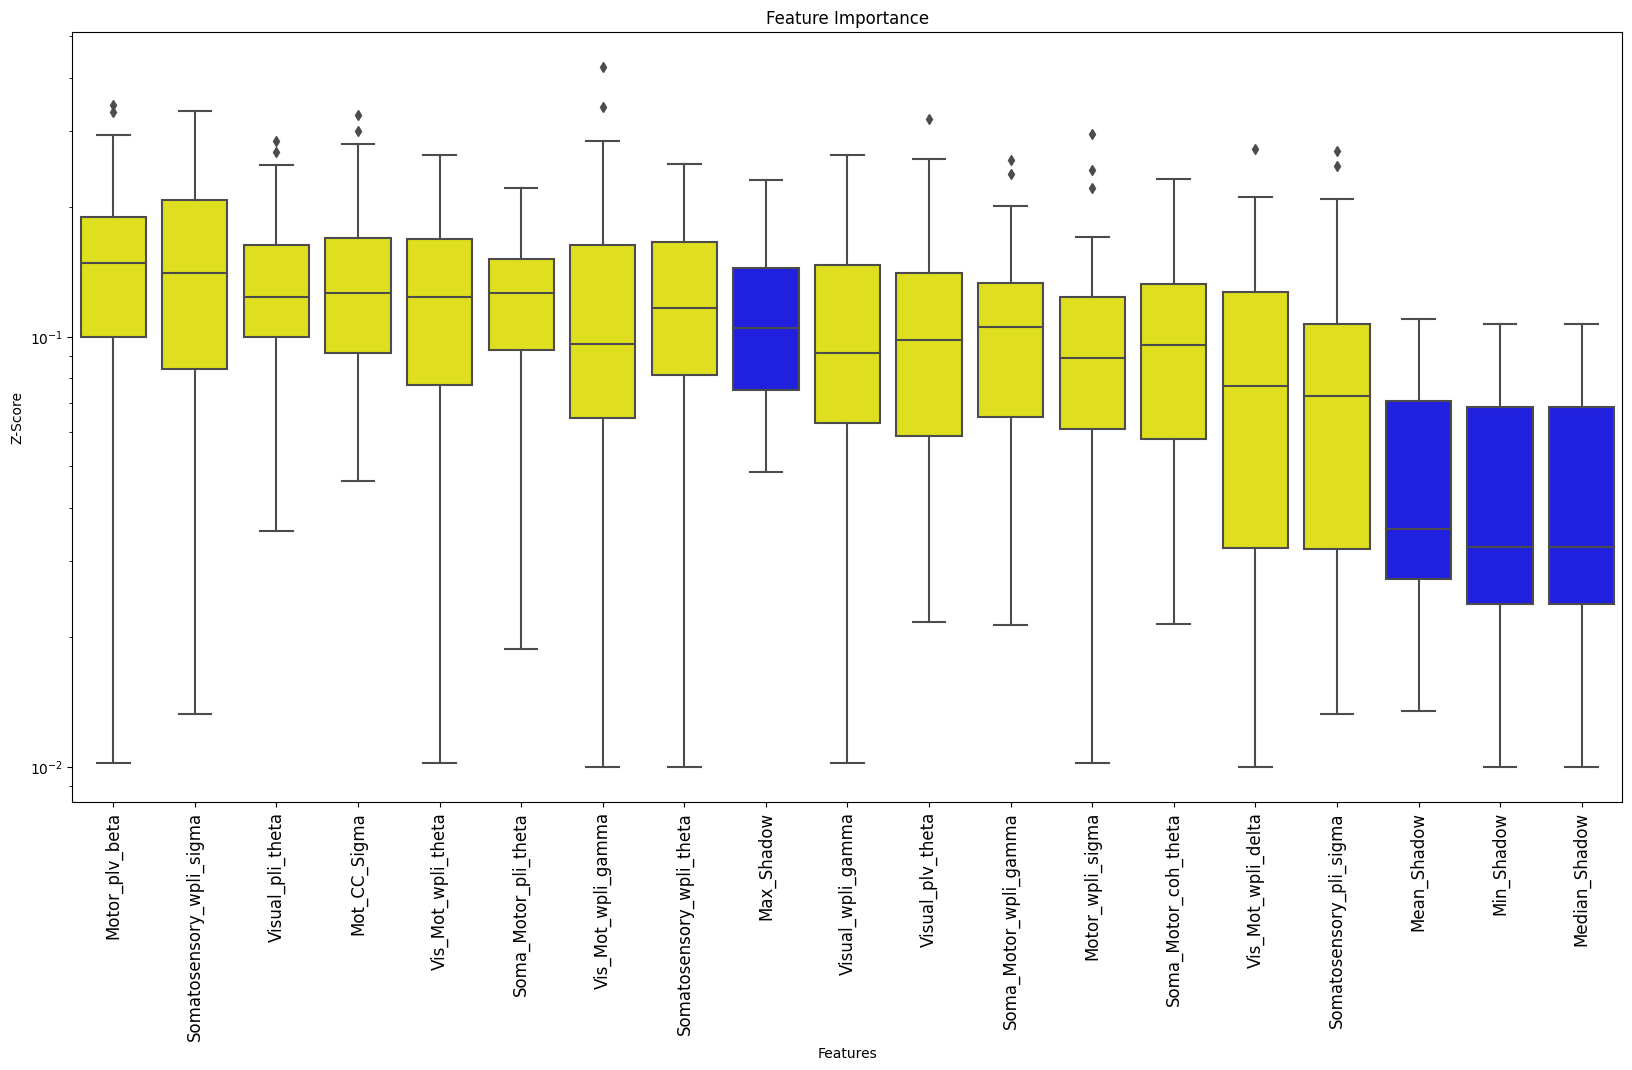

In [21]:
borutashap.plot(X_size=12, figsize=(20,10),
            y_scale='log', which_features='tentative')